# Optimized PLSR performance with depth  

Here, PLSR (as optimized through 10f-Xval) is tested in artificially made data (see Data augmentation poisson noise.ipynb) that simulates light scattering in the  Raman signals as we go deep in brain tissue (brain organoid)

In [2]:
import numpy as np
import pandas as pd
import scipy.io as scp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as sts
import xlsxwriter 
import scipy as scy
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('seaborn-paper')
from sklearn.model_selection import KFold,train_test_split
from itertools import chain, repeat
from sklearn.metrics import r2_score,mean_squared_error
from scipy import signal
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.decomposition import PCA
import cv2
from cv2 import dilate
from matplotlib import cm
from scipy import ndimage
from sklearn.cross_decomposition import PLSRegression
plt.rc('text',usetex=True)

In [3]:
Data_depth = dict()
for depth in range(0,105,5):
    Data_depth[str(depth)]=pd.read_excel('Depth_noisy_data.xlsx',sheet_name=str(depth),index_col = [0])

In [4]:
Data_depth.keys()

dict_keys(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', '95', '100'])

In [5]:
#PLSR model with selected wavelengths-> Optimized through 10f-Xval
wavs = np.array([612, 286, 574, 401, 409, 554, 183, 153, 642, 589, 601, 243, 558,
       622, 147, 611, 639, 537, 631, 575, 185,  51, 532, 285, 423, 603,
        72, 553, 577, 479, 118,  86, 573, 628, 544, 620, 244, 586, 547,
       265, 160, 141, 551,  84, 566,  66, 315, 339, 128, 585, 582, 332,
       534, 593, 337, 123, 630, 372,  67, 615, 629, 180, 609, 384, 120,
       608, 563,  70, 552, 548, 610,  68,  69, 565, 572, 146, 583, 637,
       638, 564])

In [6]:
# Define opt wav PLS model (34 ppal comps) -> Optimized through 10f-Xval
model = PLSRegression(n_components=34,scale = False)

In [8]:
#Define simple PLSR (34 ppal cmps)-> Optimized through 10f-Xval
PLSR_model = PLSRegression(n_components = 34, scale = False)

In [9]:
calib_data = pd.read_excel('Calib_no_silent_one_rep.xlsx',index_col = [0])

In [10]:
X = calib_data.iloc[:,3:].values
y = calib_data.iloc[:,:3].values

In [28]:
#Optimal wavelengths for PLSR modeling
X_opt = X[:,wavs]

In [29]:
X_opt2 = X

In [30]:
model.fit(X_opt,y)

PLSRegression(copy=True, max_iter=500, n_components=34, scale=False, tol=1e-06)

In [31]:
PLSR_model.fit(X_opt2,y)

PLSRegression(copy=True, max_iter=500, n_components=34, scale=False, tol=1e-06)

In [32]:
R2 = []
RMSE = []
RMSE_DNA = []
RMSE_Prot = []
RMSE_lipid = []

for key in list(Data_depth.keys()):
    # Watch out!! -> Check which model is being used (opt wav. PLSR or simple PLSR)
    preds = model.predict(Data_depth[key].iloc[:,3:].values[:,wavs])
    preds[preds<0]=0
    pred_DNA = preds[:,0]
    pred_Prot = preds[:,1]
    pred_Lipid = preds[:,2]

    #metrics 
    RMSE.append(np.sqrt(mean_squared_error(y,preds)))
    R2.append(r2_score(y,preds))
    RMSE_DNA.append(np.sqrt(mean_squared_error(y[:,0],pred_DNA)))
    RMSE_Prot.append(np.sqrt(mean_squared_error(y[:,1],pred_Prot)))
    RMSE_lipid.append(np.sqrt(mean_squared_error(y[:,2],pred_Lipid)))

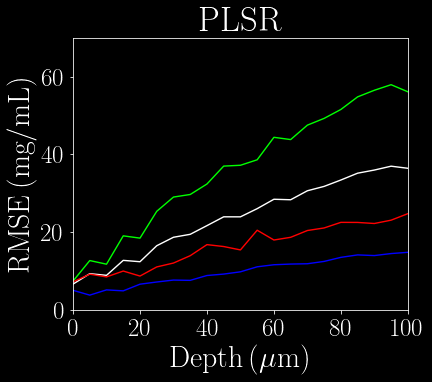

In [33]:
plt.style.use('dark_background')

fig = plt.figure(figsize=(6,5))
depth_range = np.arange(0,105,5)
plt.plot(depth_range,RMSE,label = '$\mathrm{Overall}$',color='white')
plt.plot(depth_range,RMSE_Prot,label = '$\mathrm{Protein}$',color='lime')
plt.plot(depth_range,RMSE_DNA,label = '$\mathrm{DNA}$',color='blue')
plt.plot(depth_range,RMSE_lipid,label = '$\mathrm{Lipid}$',color='red')
#plt.legend(fontsize=20,ncol =1)
plt.tick_params(labelsize=25)
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.title('$\mathrm{PLSR}$',fontsize=35)
plt.xlabel('$\mathrm{Depth\,(\mu m)}$',fontsize=30)
plt.ylabel('$\mathrm{RMSE\,(mg/mL)}$',fontsize=30)
plt.xlim((0,100))
plt.ylim((0,70))
fig.savefig('backgr opt wav PLSR  RMSE performance depth.png',bbox_inches='tight',dpi=400)

In [34]:
mean_prot = np.mean(y[:,1])
mean_lipid = np.mean(y[:,2])
mean_DNA = np.mean(y[:,0])
mean_overall = np.mean(y)

print('Mean overall:',mean_overall,'mg/mL')
print('Mean DNA:',mean_DNA,'mg/mL')
print('Mean prot:',mean_prot,'mg/mL')
print('Mean lipid:',mean_lipid,'mg/mL')

Mean overall: 27.129166666666666 mg/mL
Mean DNA: 10.275 mg/mL
Mean prot: 49.6875 mg/mL
Mean lipid: 21.425 mg/mL


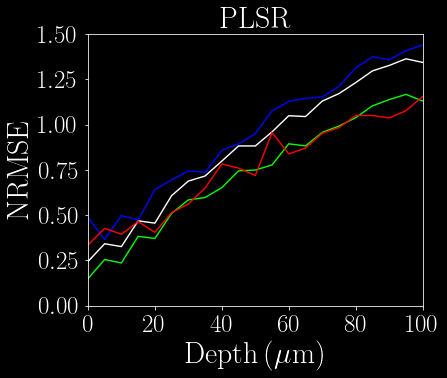

In [35]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(6,5))
depth_range = np.arange(0,105,5)
plt.plot(depth_range,np.array(RMSE)/mean_overall,label = '$\mathrm{Overall}$',color='white')
plt.plot(depth_range,np.array(RMSE_Prot)/mean_prot,label = '$\mathrm{Protein}$',color='lime')
plt.plot(depth_range,np.array(RMSE_DNA)/mean_DNA,label = '$\mathrm{DNA}$',color='blue')
plt.plot(depth_range,np.array(RMSE_lipid)/mean_lipid,label = '$\mathrm{Lipid}$',color='red')
#plt.legend(fontsize=19)
plt.tick_params(labelsize=25)
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.xlabel('$\mathrm{Depth\,(\mu m)}$',fontsize=30)
plt.ylabel('$\mathrm{NRMSE}$',fontsize=30)
plt.title('$\mathrm{PLSR}$',fontsize=30)
plt.xlim((0,100))
plt.ylim((0,1.5))
fig.savefig('black backgr opt wav PLSR NRMSE performance depth.png',bbox_inches='tight',dpi=300)

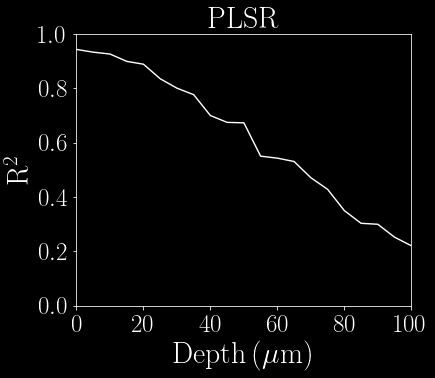

In [36]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(6,5))
plt.plot(depth_range,R2,color='white')
plt.tick_params(labelsize=20)
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.title('$\mathrm{PLSR}$',fontsize=30)
plt.xlabel('$\mathrm{Depth\,(\mu m)}$',fontsize=30)
plt.ylabel('$\mathrm{R^2}$',fontsize=30)
plt.tick_params(labelsize=25)
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.xlim((0,100))
plt.ylim((0,1))
fig.savefig('Black backgr opt wav PLSR R2 performance depth.png',bbox_inches='tight',dpi=300)

## Twin plot

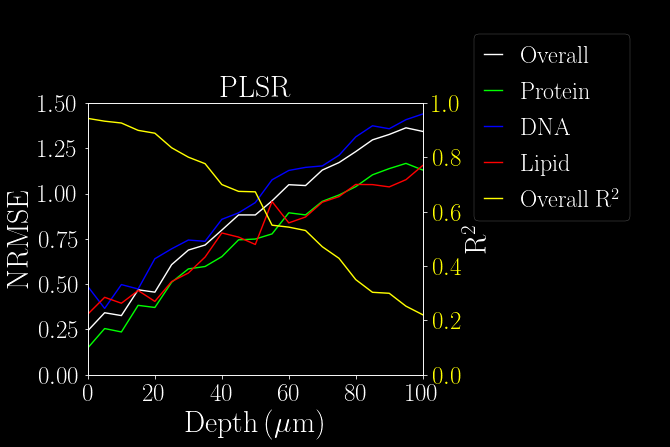

In [59]:
plt.style.use('dark_background')
fig, ax1 = plt.subplots(figsize=(6,5))
ax2 = ax1.twinx()
depth_range = np.arange(0,105,5)
p1=ax1.plot(depth_range,np.array(RMSE)/mean_overall,label = '$\mathrm{Overall}$',color='white')
p2=ax1.plot(depth_range,np.array(RMSE_Prot)/mean_prot,label = '$\mathrm{Protein}$',color='lime')
p3=ax1.plot(depth_range,np.array(RMSE_DNA)/mean_DNA,label = '$\mathrm{DNA}$',color='blue')
p4=ax1.plot(depth_range,np.array(RMSE_lipid)/mean_lipid,label = '$\mathrm{Lipid}$',color='red')
ax1.tick_params(labelsize=25)
ax1.locator_params(axis='x', nbins=6)
ax1.locator_params(axis='y', nbins=6)
ax1.set_xlabel('$\mathrm{Depth\,(\mu m)}$',fontsize=30)
ax1.set_ylabel('$\mathrm{NRMSE}$',fontsize=30)
ax1.set_title('$\mathrm{PLSR}$',fontsize=30)
ax1.set_xlim((0,100))
ax1.set_ylim((0,1.5))



p5 = ax2.plot(depth_range,R2,color='yellow',label ='$\mathrm{Overall\: R^2}$')
ax2.tick_params(labelsize=20)
ax2.locator_params(axis='x', nbins=6)
ax2.locator_params(axis='y', nbins=6)
ax2.set_ylabel('$\mathrm{R^2}$',fontsize=30)
ax2.tick_params(labelsize=25,labelcolor='yellow',axis='y')
ax2.set_ylim((0,1))

fig.legend(bbox_to_anchor=(1.485, 1.18),fontsize = 24,handlelength=0.75)
fig.savefig('blackgr opt wav PLSR (NRMSE & R2).png',bbox_inches='tight',dpi=300)